# Подготовка и анализ результатов A/B теста

## Описание проекта

Отдел маркетинга интернет-магазина подготовил список гипотез для увеличения выручки. Необходимо приоритизировать гипотезы, выделив самые перспективные, а так же провести A/B тест и проанализировать его результаты.

**Цель проекта**:
1. Выбрать наиболее перспективные гипотезы для последующего запуска A/B тестирования;
2. Принять решение о дальнейшем проведении A/B тестирования и оценка его результатов.

Задачи проекта:
1. Провести приоритизацию гипотез;
2. Обработать данные, полученные в ходе A/B теста, провести статистический анализ гипотез результатов.  

**План действий**:
1. Провести предобработку данных;
2. Для приоритизации гипотез использовать фреймворки ICE и RICE;
3. Собрать кумулятивные данные;
4. Построить график кумулятивной выручки и кумулятивного среднего чека;
5. Проанализировать и обработать аномалии и выбросы;
6. Посчитать статистическую значимость различий в конверсии и среднем чеке между группами по "сырым" данным;
7. Посчитать статистическую значимость различий в конверсии и среднем чеке между группами по "очищенным" данным;
8. Оценить полученные результаты.

**Описание данных**

Данные таблицы **hypothesis**:

* _Hypothesis_ — краткое описание гипотезы;
* _Reach_ — охват пользователей по 10-балльной шкале;
* _Impact_ — влияние на пользователей по 10-балльной шкале;
* _Confidence_ — уверенность в гипотезе по 10-балльной шкале;
* _Efforts_ — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Данные таблицы **orders**:

* _transactionId_ — идентификатор заказа;
* _visitorId_ — идентификатор пользователя, совершившего заказ;
* _date_ — дата, когда был совершён заказ;
* _revenue_ — выручка заказа;
* _group_ — группа A/B-теста, в которую попал заказ.

Данные таблицы **visitors**:

* _date_ — дата;
* _group_ — группа A/B-теста;
* _visitors_ — количество пользователей в указанную дату в указанной группе A/B-теста

## Приоритизация гипотез

In [14]:
import pandas as pd  # импорт библиотек
from scipy import stats as st
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np

In [15]:
hypothesis = pd.read_csv('datasets\\hypothesis.csv') # чтение файла с гипотезами
pd.set_option('display.max_colwidth', None)  
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Всего отдел маркетинга предоставил девять гипотез, у каждой уже рассчитаны необходимые параметры. Для расчета приоритета у нас есть два метода, **ICE** и его модификация **RICE**. Проверим каждый из них: рассчитаем данные, добавим столбец и отсортируем результаты.

In [16]:
hypothesis.columns = [x.lower() for x in hypothesis.columns.values] # переименовываю столбцы для удобства

In [17]:
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']).round(2) # расчет ICE
hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


По результатам ICE наиболее перспективными гипотезами являются 9, 1 и 8. Однако, есть еще один способ расчета: RICE, который так же учитывает, сколько пользователей затронет исследуемое изменение.

In [18]:
# расчет RICE
hypothesis['RICE'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'])
hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


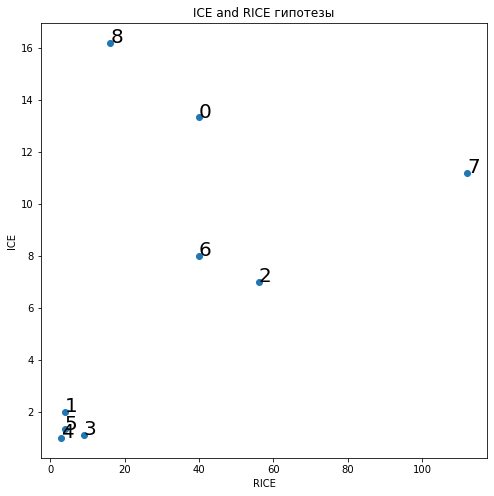

In [19]:
y = hypothesis['ICE']   # визуализация результатов на точечной диаграмме
z = hypothesis['RICE'] 
n = hypothesis.index 

fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(8) 
ax.scatter(z, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i], y[i]), size=20)

plt.title("ICE and RICE гипотезы") 
plt.xlabel("RICE") 
plt.ylabel("ICE")
plt.show()  

Здесь произошли небольшие сдвиги: самой перспективной гипотезой является 8, за ней 3, 1 и 7.

8 гипотеза вышла на первое место, потому что охват ее изменений касается всех пользователей, которые посещают сайт интернет-магазина. А вот гипотеза о добавлении акций в день рождения, наоборот, сильно просела в рейтинге из-за своего узкого эффекта на аудиторию.

Таким образом, нельзя делать выбор по приоритизации гипотез, основываясь только на одном методе, расчеты по формуле ICE сильно зависят от субъективной оценки гипотезы, тогда как его модернизированная версия RICE учитывает так же будущий охват изменений. В нашем случае на основании двух методов **наиболее перспективными будут гипотезы под номерами 8, 1 и 3**.

## Анализ результатов A/B теста

### Подготовка данных

In [20]:
orders = pd.read_csv('datasets\\orders.csv') # чтение файлов
visitors = pd.read_csv('datasets\\visitors.csv')

In [21]:
print(orders.info()) # общая информация о таблице orders
display(orders)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


In [22]:
print(visitors.info()) # общая информация о таблице visitors
display(visitors)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


In [23]:
orders = orders.rename(columns={'transactionId': 'transaction_id',  # для удобства переименовываю столбцы
                               'visitorId': 'visitor_id'})
visitors.columns = ['date', 'group', 'daily_visitors']

In [24]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))  # переводим дату в правильный формат
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [25]:
print(orders.duplicated().sum()) # проверка на явные дубликаты
print(visitors.duplicated().sum())

0
0


In [26]:
print(f"Начало проведения тестирования {orders['date'].min()}") # минимальная и максимальная дата исследования
print(f"Окончание проведения тестирования {orders['date'].max()}")

Начало проведения тестирования 2019-08-01 00:00:00
Окончание проведения тестирования 2019-08-31 00:00:00


Судя по данным, тестирование проводилось ровно один месяц с 1 августа по 31 августа 2019 года. 

In [27]:
print(f"Количество пользователей в группе А {visitors[visitors['group'] == 'A']['daily_visitors'].sum()}") 
print(f"Количество пользователей в группе B {visitors[visitors['group'] == 'B']['daily_visitors'].sum()}") 

Количество пользователей в группе А 18736
Количество пользователей в группе B 18916


### Анализ кумулятивных данных

Прежде всего агрегируем данные с накоплением результатов и представим их графиками, так мы увидим динамику проведения теста и возможные выбросы.

In [28]:
dates_group = orders[['date','group']].drop_duplicates() # уникальные пары "дата-группа" 

In [29]:
# агрегируем данные: сортируем таблицу orders по условию, 
# затем считаем число уникальных транзакций и пользователей, сумму покупок, 
# код проходит по каждой строке датафрейма

agregated_orders = (dates_group
                    .apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'],
                                                           orders['group'] == x['group'])]
                           .agg(
                               {
                                   'date': 'max',
                                   'group': 'max',
                                   'transaction_id': 'nunique',
                                   'visitor_id': 'nunique',
                                   'revenue': 'sum'
                               }
                           ), axis=1)
                    .sort_values(by=['date', 'group'])
                   )

# аналогичный расчет по данных о количестве пользователей в день

agregated_visits = (dates_group
                    .apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'],
                                                             visitors['group'] == x['group'])]
                           .agg(
                               {
                                   'date': 'max',
                                   'group': 'max',
                                   'daily_visitors': 'sum'
                               }
                           ), axis=1)
                    .sort_values(by=['date', 'group'])
                    )

In [30]:
# объединяем полученные таблицы в одну методом merge
# переименовываем столбцы

df_cummulative = agregated_orders.merge(agregated_visits, on=['date', 'group']) 
df_cummulative.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
df_cummulative

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845
...,...,...,...,...,...,...
57,2019-08-29,B,596,544,5559398,17708
58,2019-08-30,A,545,493,4022970,18037
59,2019-08-30,B,620,567,5774631,18198
60,2019-08-31,A,557,503,4084803,18736


In [31]:
# проверка на корректность объединения датафрейма
print(f"Начало проведения тестирования {df_cummulative['date'].min()}") 
print(f"Окончание проведения тестирования {df_cummulative['date'].max()}")

Начало проведения тестирования 2019-08-01 00:00:00
Окончание проведения тестирования 2019-08-31 00:00:00


Таблица готова, пора строить графики. Для начала выведем общий с кумулятивной выручкой в каждой группе.

In [32]:
# разделим общую таблицу на две части по каждой группе

cummulative_a = df_cummulative.query('group == "A"')[['date', 'orders', 'buyers', 'revenue', 'visitors']] # группа А
cummulative_b = df_cummulative.query('group == "B"')[['date', 'orders', 'buyers', 'revenue', 'visitors']] # группа B

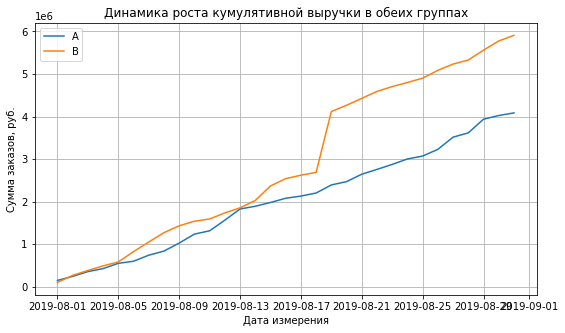

In [33]:
plt.figure(figsize=(9,5))  # график динамики роста кумулятивной выручки
plt.plot(cummulative_a['date'], cummulative_a['revenue'], label='A')
plt.plot(cummulative_b['date'], cummulative_b['revenue'], label='B')
plt.legend()
plt.grid()
plt.xlabel('Дата измерения')
plt.ylabel('Сумма заказов, руб.')
plt.title('Динамика роста кумулятивной выручки в обеих группах')
plt.show()

На графике виден рост в обеих группах, однако **у группы B явно присутствует резкий скачок** в период 18 августа, велика вероятность, что этот результат обусловлен выбросами в сумме заказов или всплеске их общего количества. У группы А рост более равномерный.

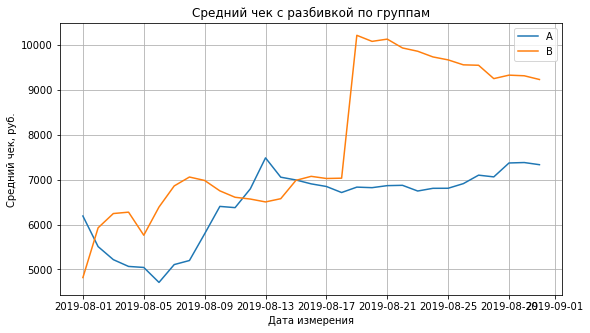

In [34]:
plt.figure(figsize=(9,5))  # динамика кумулятивного среднего чека
plt.plot(cummulative_a['date'], (cummulative_a['revenue']/cummulative_a['orders']), label='A')
plt.plot(cummulative_b['date'], (cummulative_b['revenue']/cummulative_b['orders']), label='B')
plt.legend()
plt.grid()
plt.xlabel('Дата измерения')
plt.ylabel('Средний чек, руб.')
plt.title('Средний чек с разбивкой по группам')
plt.show()

Здесь уже интересно: средний чек группы A в целом стабилизируется, тогда как у группы B он продолжает падать, причем после огромного скачка в тот же период, что и на предыдущем графике. Ситуацию дестабилизировало наличие каких-то крупных заказов в определенную дату.

Посмотрим, насколько изменялся средний чек B относительно группы А.

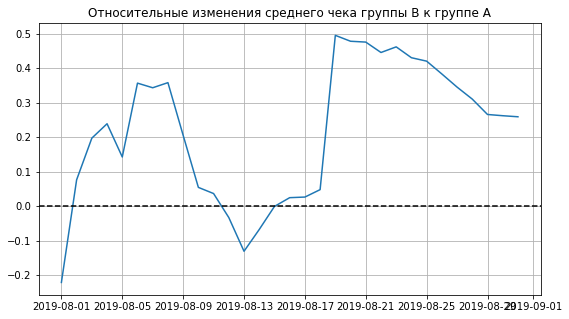

In [35]:
# сведем данные о покупках в одну таблицу
merge_cummulative = cummulative_a.merge(cummulative_b,
                                              on='date',
                                              suffixes=['_A', '_B'])

# строим график относительных изменений среднего чека
plt.figure(figsize=(9,5))
plt.plot(merge_cummulative['date'], (merge_cummulative['revenue_B']/merge_cummulative['orders_B'])/
                           (merge_cummulative['revenue_A']/merge_cummulative['orders_A'])-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.grid()
plt.title('Относительные изменения среднего чека группы B к группе A')
plt.show()

График изменений сильно скачет, особенно с 18 по 19 августа, где-то там есть огромный выброс, средний чек вырос в тот момент на целых 50% процентов относительно контрольной группы.

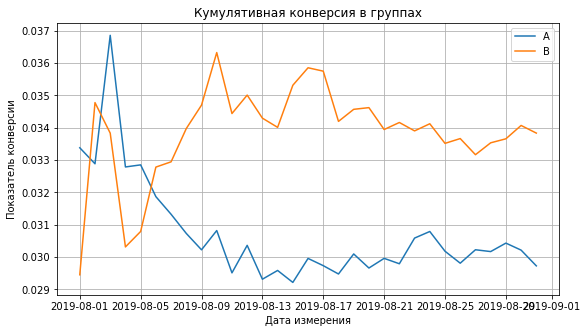

In [36]:
# считаем конверсию
cummulative_a['conversion'] = cummulative_a['orders'] / cummulative_a['visitors']
cummulative_b['conversion'] = cummulative_b['orders'] / cummulative_b['visitors']

# строим график кумулятивной конверсии
plt.figure(figsize=(9,5))
plt.plot(cummulative_a['date'], cummulative_a['conversion'], label='A')
plt.plot(cummulative_b['date'], cummulative_b['conversion'], label='B')
plt.legend()
plt.grid()
plt.xlabel('Дата измерения')
plt.ylabel('Показатель конверсии')
plt.title('Кумулятивная конверсия в группах')
plt.show()

График почти симметричен, конверсия группы B после колебаний сразу вырвалась вперед и выше чем в контрольной группе, стоит посмотреть, в каком относительном показателе группа B лидирует.

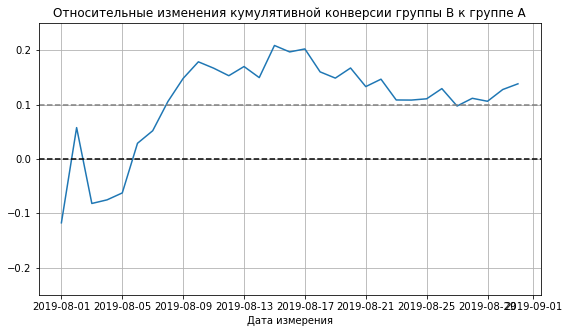

In [37]:
# объединяем конверсии
merge_conversions = cummulative_a[['date', 'conversion']].merge(cummulative_b[['date', 'conversion']],
                                                               on='date',
                                                               suffixes=['_A', '_B'])
# строим график относительных изменений

plt.figure(figsize=(9,5))
plt.plot(merge_conversions['date'], merge_conversions['conversion_B']/merge_conversions['conversion_A']-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='gray', linestyle='--')
plt.grid()
plt.ylim([-0.25, 0.25])
plt.title('Относительные изменения кумулятивной конверсии группы B к группе A')
plt.xlabel('Дата измерения')
plt.show()

Конверсия группы В относительно А почти сразу ушла в отрыв, затем был небольшой спад, а сейчас она снова на подъеме, причем относительно контрольной группы прирост составляет минимум 10% практически с начала тестирования.

### Анализ выбросов и поиск аномалий

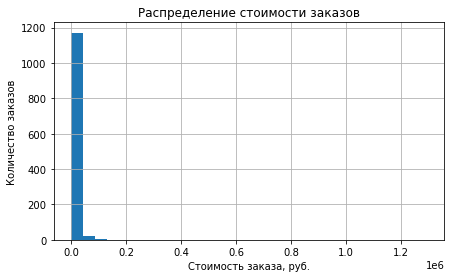

In [38]:
plt.figure(figsize=(7,4))   # гистограмма стоимости заказов
plt.hist(orders['revenue'], bins=30)
plt.grid()
plt.title('Распределение стоимости заказов')
plt.xlabel('Стоимость заказа, руб.')
plt.ylabel('Количество заказов')
plt.show()

Подавляющая сумма заказов находится в пределах до 100 тысяч, по грубой оценке. По гистограмме сложно идентифицировать аномалии, но по крайней мере мы видим, что они действительно есть.

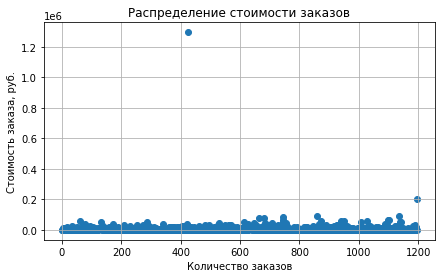

In [39]:
x_value = pd.Series(range(0,len(orders['revenue'])))  # точечная диаграмма распределения суммы заказов 
                                                      # и количества пользователей
plt.figure(figsize=(7,4))
plt.scatter(x_value, orders['revenue'])
plt.grid()
plt.title('Распределение стоимости заказов')
plt.ylabel('Стоимость заказа, руб.')
plt.xlabel('Количество заказов')
plt.show()

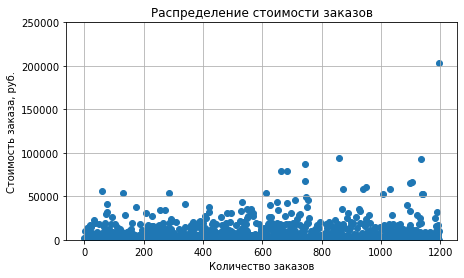

In [40]:
plt.figure(figsize=(7,4))   # ограничим ось y для наглядности стоимости покупок
plt.scatter(x_value, orders['revenue'])
plt.ylim([0,250000])
plt.grid()
plt.title('Распределение стоимости заказов')
plt.ylabel('Стоимость заказа, руб.')
plt.xlabel('Количество заказов')
plt.show()

Действительно, большая часть заказов не превышает сумму в 25 тысяч рублей. Догадки о выбросах подтверждаются: у нас есть минимум два аномальных заказа, которые искажают средний чек. Предположительно граница таких заказов начинается со шестидесяти тысяч рублей и выше. Добавим точности и вычислим перцентили.

In [41]:
np.percentile(orders['revenue'], [90,95,99]) # считаем перцентили

array([18168. , 28000. , 58233.2])

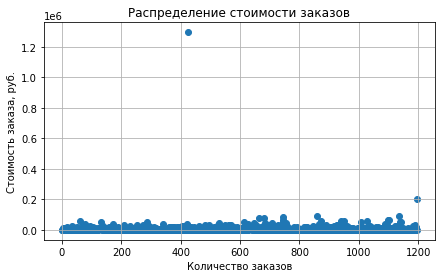

In [42]:
x_value = pd.Series(range(0,len(orders['revenue'])))  # точечная диаграмма распределения суммы заказов 
                                                      # и количества пользователей
plt.figure(figsize=(7,4))
plt.scatter(x_value, orders['revenue'])
plt.grid()
plt.title('Распределение стоимости заказов')
plt.ylabel('Стоимость заказа, руб.')
plt.xlabel('Количество заказов')
plt.show()

Не более 5% заказов дороже 28 тысяч рублей и не более 1% дороже 58 тысяч. 90% всех заказов расположены в диапазоне до 18 тысяч рублей. По результатам расчетов определимся с тем, что отсечем **до 1% наблюдений с крайними значениями и оставим границу в 58 тысяч рублей.**

С аномалиями в сумме заказов разобрались, теперь стоит проверить покупателей на количество заказов, так как особо активные пользователи могли повлиять на наши расчеты конверсии.

In [29]:
# группируем данные по каждому пользователю и количеству заказов

orders_by_users = (orders
                   .groupby('visitor_id', as_index=False)
                   .agg({'transaction_id': 'nunique'})
                   .rename(columns={'transaction_id': 'orders'})
                  )
orders_by_users.sort_values(by='orders', ascending=False).head(10)

,visitor_id,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


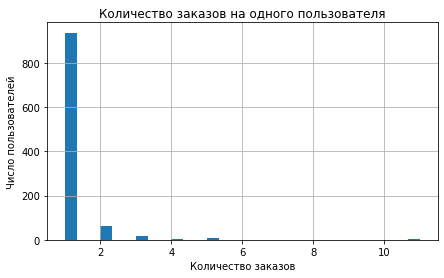

In [30]:
plt.figure(figsize=(7,4))   # гистограмма количества покупок
plt.hist(orders_by_users['orders'], bins=30)
plt.grid()
plt.title('Количество заказов на одного пользователя')
plt.xlabel('Количество заказов')
plt.ylabel('Число пользователей')
plt.show()

Подавляющее большинство совершает не более одного заказа.

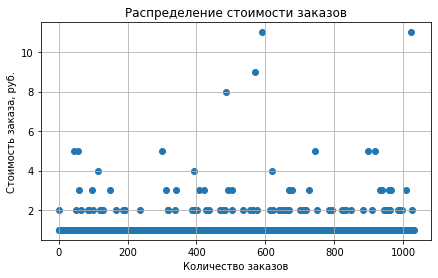

In [31]:
x_value = pd.Series(range(0, len(orders_by_users))) # строим точечную диаграмму распределения количества заказов

plt.figure(figsize=(7,4))
plt.scatter(x_value, orders_by_users['orders'])
plt.grid()
plt.title('Распределение стоимости заказов')
plt.ylabel('Стоимость заказа, руб.')
plt.xlabel('Количество заказов')
plt.show()

Некоторая доля пользователей совершает и два, и даже пять заказов, подсчет выборочных перцентилей подскажет нам, считать их аномалиями или нет.

In [32]:
np.percentile(orders_by_users['orders'], [90,95,99])

array([1., 2., 4.])

Не более 5% совершают больше 2 заказов и не более 1% - больше 4 заказов. С учетом результатов можно провести нижнюю границу для аномалий от 4 заказов и выше.

### Расчет статистической значимости результатов теста по "сырым" данным

Чтобы определиться, продолжать проводить тест или нет, нужно узнать, насколько статистически значимы различия между группами. Для этого мы сравним различия в среднем чеке и конверсию: в понимании этой работы конверсия - это отношение среднего количества заказов на каждого пользователя. Для проведения анализа нам потребуются данные о ежедневном посещении интернет-магазина и количестве заказов ежедневно. Кумулятивные данные у нас есть с предыдущих графиков, просто добавим к ним данные о ежедневном посещении пользователей и количестве заказов, получив таким образом полную таблицу расчетов.

In [33]:
daily_orders = (   # количество заказов ежедневно
    orders[['date', 'group', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby(['date', 'group'], as_index=False)
    .agg({'transaction_id': 'nunique', 'revenue': 'sum'})
)
daily_orders.columns = ['date', 'group', 'daily_orders', 'daily_revenue']

# сведем все вместе для удобства

df = (df_cummulative
      .merge(visitors, on=['date', 'group'])      # данные о ежедневных посещениях уже есть в visitors,
      .merge(daily_orders, on=['date', 'group'])  # добавляем данные о ежедневных заказах
     )

Далее - выделим в отдельные переменные пользователей с каждой группы, кто сделал хотя бы один заказ.

In [34]:
users_orders_a = (  # данные группы А
    orders
    .query('group == "A"')
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
    .rename(columns={'transaction_id': 'orders'})
)

users_orders_b = (  # данные группы В
    orders
    .query('group == "B"')
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
    .rename(columns={'transaction_id': 'orders'})
)

Для проверки критерием Уилкоксона-Манна-Уитни сделаем итоговые переменные `sample_a` и `sample_b` c данными о пользовательских покупках; для анализа тем, кто ничего не заказал, нужно будет проставить нули. Для этого объединим предыдущие переменные с объектом Series с нулями нужной длины.

In [35]:
sample_a = pd.concat([users_orders_a['orders'],   # sample_a - данные о покупателях, сделавших хотя бы одну покупку
                     pd.Series(0,                 # для всех остальных проставляем нули
                               index=np.arange(
                                   df.query('group == "A"')['daily_visitors'].sum() - len(users_orders_a['orders'])), 
                               name='orders')],
                    axis=0)

sample_b = pd.concat([users_orders_b['orders'],   # sample_b строится аналогично
                     pd.Series(0, 
                               index=np.arange(
                                   df.query('group == "B"')['daily_visitors'].sum() - len(users_orders_b['orders'])), 
                               name='orders')],
                    axis=0)

Данные готовы для первой проверки: в переменных `sample` число элементов - это общее число пользователей, а их сумма - общее количество заказов, следовательно, среднее число заказов на одного пользователя можно узнать методом mean() в применении к выборке. 

Пора сформулировать **нулевую и альтернативную гипотезу**, помним, что нулевая должна сохранять в себе знак равенства, поэтому гипотезы будут звучать так:

* **H₀ - Между группами нет различий в среднем количестве заказов.**
* **H₁ -  В среднем количестве заказов между группами имеется статистическая разница.**

In [36]:
alpha = 0.01 #  уровень статистической значимости 1% 

results = st.mannwhitneyu(sample_a, sample_b)  # проводим тест

print("Значение p-value: {0:.3f}".format(results.pvalue))
print("Соотношение среднего количества заказов группы B к группе A: {0:.3f}".format(sample_b.mean()/sample_a.mean() - 1))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу, разница статистически значима')
else:
    print('Нулевая гипотеза не отвергается')

Значение p-value: 0.017
Соотношение среднего количества заказов группы B к группе A: 0.138
Нулевая гипотеза не отвергается


Так как мы хотим добиться высокой точности в результатах теста, а наша выборка пользователей в каждой группе составляет более 18 тысяч пользователей, будет целесообразно определить уровень статистической значимости альфа как 0.01.

При критическом уровне статистической значимости в 1% **разница между двумя группами не является статистически значимой.** По "сырым" показателям показатель p_value всего 1,7%, если ориентироваться на другой уровень alpha, например, 5%, то мы бы отвергли нулевую гипотезу. 

С учетом соотношения средних показателей количества пользователей группа B обошла контрольную группу с результатом в 13,8%.

 Проверим статистическую значимость различий в среднем чеке по "сырым" данным. Как и в предыдущем случае, формулируем нулевую и альтернативную гипотезы:
 
* **H₀: Нет различий в среднем чеке между группами A и B.**
* **H₁: Между группами наблюдаются различия в среднем чеке.**

In [37]:
alpha = 0.01 #  уровень статистической значимости 1% 

results = st.mannwhitneyu(orders.query('group == "A"')['revenue'],orders.query('group == "B"')['revenue'])

print("Значение p-value: {0:.3f}".format(results.pvalue))
print("Относительные различия среднего чека группы В к группе А: {0:.3f}"
      .format(orders.query('group == "B"')['revenue'].mean()/orders.query('group == "A"')['revenue'].mean() - 1))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу, разница статистически значима')
else:
    print('Нулевая гипотеза не отвергается')

Значение p-value: 0.729
Относительные различия среднего чека группы В к группе А: 0.259
Нулевая гипотеза не отвергается


Результаты теста по "сырым" данным сигнализируют о том, что **статистической разницы между показаниями среднего чека двух групп не наблюдается**, причем группа B обыгрывает группу А на 25,9%; по итогу нулевая гипотеза не отвергается.

### Анализ статистической значимости результатов теста с учетом аномалий

Пора взяться за найденные раньше выбросы, "почистить" данные и провести тесты заново. В прошлый раз мы определились, что уберем 1% пользователей с наибольшим количеством заказов и 1% пользователей с дорогимим заказами - это нижние границы в 4 заказа и 58 тысяч соответственно.

In [38]:
revenue_limit = np.percentile(orders['revenue'], [99])[0] # нижние границы
orders_limit = np.percentile(orders_by_users['orders'], [99])[0]

 # id "особо активных" пользователей
many_orders = pd.concat([users_orders_a.query('orders > @orders_limit')['visitor_id'], 
                        users_orders_a.query('orders > @orders_limit')['visitor_id']], axis=0) 

# id юзеров с большими заказами
expensive_orders = orders.query('revenue > @revenue_limit')['visitor_id']

abnormal_users = pd.concat([many_orders, expensive_orders], axis=0) # соединяем список 
abnormal_users.shape[0]

18

Итого мы нашли 18 аномальных пользователей. Отфильтруем данные и проводем анализ еще раз.

In [39]:
# переменные sample_a и sample_b, отфильтрованные с учетом аномальных пользователей
sample_a_filtered = pd.concat([users_orders_a.query('visitor_id not in @abnormal_users')['orders'],
                     pd.Series(0, 
                               index=np.arange(
                                   df.query('group == "A"')['daily_visitors'].sum() - len(users_orders_a['orders'])), 
                               name='orders')],
                    axis=0)

sample_b_filtered = pd.concat([users_orders_b.query('visitor_id not in @abnormal_users')['orders'],
                     pd.Series(0, 
                               index=np.arange(
                                   df.query('group == "B"')['daily_visitors'].sum() - len(users_orders_b['orders'])), 
                               name='orders')],
                    axis=0)

Гипотезы остаются прежними. Для оценки конверсии:

* **H₀ - Между группами нет различий в среднем количестве заказов.**
* **H₁ -  В среднем количестве заказов между группами имеется статистическая разница.**

In [40]:
alpha = 0.01 #  уровень статистической значимости 5% 

results = st.mannwhitneyu(sample_a_filtered, sample_b_filtered)

print("Значение p-value: {0:.3f}".format(results.pvalue))
print("Соотношение среднего количества заказов группы B к группе A: {0:.3f}"
      .format(sample_b_filtered.mean()/sample_a_filtered.mean() - 1))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу, разница статистически значима')
else:
    print('Нулевая гипотеза не отвергается')

Значение p-value: 0.014
Соотношение среднего количества заказов группы B к группе A: 0.154
Нулевая гипотеза не отвергается


Результат "очищенных" данных почти не отличается от предыдущего: 1,4% статистической значимости против 1,7%. **Нулевая гипотеза не отвергается**: между результатами экспериментальной и контрольной группы нет разницы в среднем количестве заказов на одного пользователя.

Гипотезы для оценки показателей среднего чека:
 
* **H₀: Нет различий в среднем чеке между группами A и B.**
* **H₁: Между группами наблюдаются различия в среднем чеке.**

In [41]:
alpha = 0.01 #  уровень статистической значимости 5% 

orders_filtered = orders.query('visitor_id not in @abnormal_users')  # отсортируем аномальных пользователей

results = st.mannwhitneyu(orders_filtered.query('group == "A"')['revenue'],
                          orders_filtered.query('group == "B"')['revenue'])

print("Значение p-value: {0:.3f}".format(results.pvalue))
print("Относительные различия среднего чека группы В к группе А: {0:.3f}"
      .format(orders_filtered.query('group == "B"')['revenue'].mean()/
              orders_filtered.query('group == "A"')['revenue'].mean() - 1))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу, разница статистически значима')
else:
    print('Нулевая гипотеза не отвергается')

Значение p-value: 0.742
Относительные различия среднего чека группы В к группе А: -0.005
Нулевая гипотеза не отвергается


Показатель p_value вырос по сравнению с "сырыми" данными с 72,9% до 85,1%, поэтому у нас **нет никаких причин отвергать нулевую гипотезу**. В результате теста нет значимых статистических различий, чтобы признать, что у двух групп есть различия в среднем чеке.

Разница между двумя группами сильно сократилась с 25,9% до 0,6%! Действительно, наличие выбросов в сумме заказов сильно искажали результат, но теперь отсутствие положительной динамики развития теста становится очевидным.

## Выводы

Итак, **в первой части** работы мы провели приоритизацию гипотез методами ICE и RICE. После расчетов нами были отобраны наиболее перспективные гипотезы под:
* **8** - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
* **1** - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
* **3** - Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа

Все три гипотезы показали хороший результат при расчетах, и концентрация сил на каждой из них может в будущем положительно сказаться на развитии продаж.

Во **второй части** мы обработали данные с результатами проведенного A/B теста, и вот какие закономерности обнаружили:
* Анализ кумулятивных метрик показал, что в обеих группах выручка растет, однако в группе B присутствуют аномалии, которые ответственны за резкие скачки выручки и среднего чека: в относительных значениях средний чек группы B более чем на 25% выше контрольной группы к концу периода.
* Конверсия групп все еще нестабильна, однако группа B показывает результат стабильно выше.
* С помощью диаграмм рассеяния и расчет перцентилей были отсеяны часть аномальных заказов и пользователей, совершавших необычно большое число покупок, в обеих частях было принято решение отфильтровать 99% показателей.
* **Статистический тест среднего числа заказов и среднего чека не показал статистически значимых различий ни по "сырым" данным, ни по "очищенным".** После удаления аномальных данных итоговые результаты группы B резко ухудшились, в том числе показатель среднего чека. Однако конверсия группы B 

С учетом результатов тестов, несмотря на небольшой отрыв в конверсии группы B, между двумя группами отсутствуют статистически значимые различия, поэтому тест следует остановить.